# Graph Contrastive Learning for Nuclei Coordinate Prediction

Here I try to show how we can apply contrastive learning techniques to improve our graph neural network's ability to predict nuclei coordinates in syncytia. Graph contrastive learning helps the model learn more robust representations by creating multiple augmented views of the graph data. 

This notebook is also just a contained version of the rest of the directory, where we can run the python code. Some of my objectives with this exploration are:

- to predict the positions of nuclei that are “hidden” (not directly observed) using only the graph of connections and features.
- This tests if the topology and local interactions encode enough information to infer spatial arrangement, even when some data is missing.

- Discover if nuclei arrangement follows certain topological rules (e.g., clustering, regular spacing, loops, or domains).
- This might point to more insight into syncytia formation.





In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

#parent directory to path for importing local modules
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))

sys.path.append('..')  #parent directory
sys.path.append('../GCN')  #GCN directory for gcn_layer

from data_utils import load_data, build_graph, create_coordinate_prediction_data
from contrastive_gcn import ContrastiveGCN
from contrastive_utils import train_contrastive_model, evaluate_contrastive_model, create_graph_views

## Load and prepare data

let's load our nuclei coordinates and build a Delaunay triangulation graph.

In [2]:
coordinates = load_data('../nuclei-coordinates.csv')  
print(f"Loaded {len(coordinates)} nuclei")


#building the actual graph
G, _ = build_graph(coordinates) #build_graph has two return values, so we discard the second with _
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Create coordinate prediction data
print("---Creating coordinate prediction task-----")
data = create_coordinate_prediction_data(coordinates, G, missing_fraction=0.25)



print("--Final Overview--")
print(f"Total nodes: {data.x.shape[0]}")
print(f"Visible nodes: {data.visible_mask.sum().item()}")
print(f"Hidden nodes: {data.hidden_mask.sum().item()}")
print(f"Edges: {data.edge_index.shape[1]}")
print(f"Node features: {data.x.shape[1]} dimensions")

Loaded 3340 nuclei
Graph: 3340 nodes, 9992 edges
---Creating coordinate prediction task-----
Hiding 1152 nodes (34.5%) in 5 clusters
Keeping 2188 nodes visible for training
--Final Overview--
Total nodes: 3340
Visible nodes: 2188
Hidden nodes: 1152
Edges: 19984
Node features: 6 dimensions


## Visualize graph augmentations

Graph contrastive learning relies on creating different "views" of the same graph through augmentations. now let us visualize what these look like.

Original graph: 9992 edges
View 1: 9986 edges (6 dropped)
View 2: 9981 edges (11 dropped)


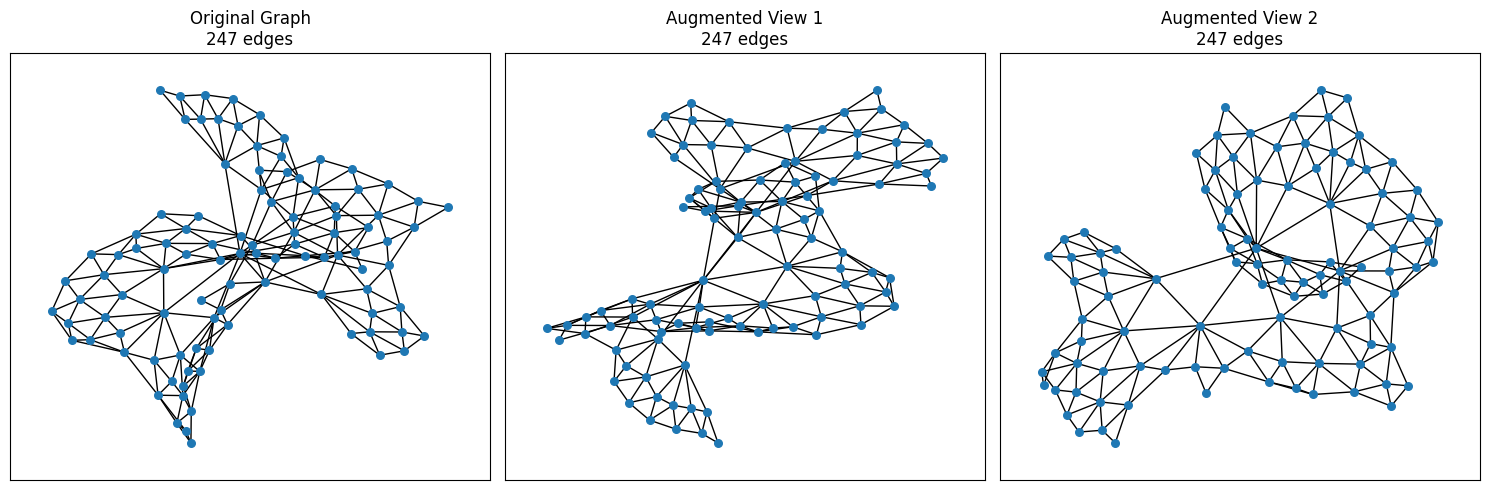

In [3]:
def visualize_graph_views(data, edge_dropout, feature_mask):
    
    """lets see different augmented views of the graph"""
    # two augmented views
    view1, view2 = create_graph_views(data, edge_dropout_prob=edge_dropout, feature_mask_prob=feature_mask)
    
    # convert this to NetworkX for visualization
    G_original = to_networkx(data, to_undirected=True)
    G_view1 = to_networkx(view1, to_undirected=True)
    G_view2 = to_networkx(view2, to_undirected=True)
    
    #alculate edge differences
    original_edges = set(G_original.edges())
    view1_edges = set(G_view1.edges())
    view2_edges = set(G_view2.edges())
    
    dropped_edges1 = original_edges - view1_edges
    dropped_edges2 = original_edges - view2_edges
    
    # Count the differences
    print(f"Original graph: {len(original_edges)} edges")
    print(f"View 1: {len(view1_edges)} edges ({len(dropped_edges1)} dropped)")
    print(f"View 2: {len(view2_edges)} edges ({len(dropped_edges2)} dropped)")
    
    # get a small subgraph for visualization (100 nodes)
    nodes_to_vis = list(range(100))
    
    sub_original = G_original.subgraph(nodes_to_vis)
    sub_view1 = G_view1.subgraph(nodes_to_vis)
    sub_view2 = G_view2.subgraph(nodes_to_vis)
    

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    nx.draw_networkx(sub_original, node_size=30, with_labels=False)
    plt.title(f"Original Graph\n{len(sub_original.edges())} edges")
    
    plt.subplot(1, 3, 2)
    nx.draw_networkx(sub_view1, node_size=30, with_labels=False)
    plt.title(f"Augmented View 1\n{len(sub_view1.edges())} edges")
    
    plt.subplot(1, 3, 3)
    nx.draw_networkx(sub_view2, node_size=30, with_labels=False)
    plt.title(f"Augmented View 2\n{len(sub_view2.edges())} edges")
    
    plt.tight_layout()
    plt.show()

# visualize graph augmentations
visualize_graph_views(data, edge_dropout=0.001, feature_mask=0.01) 

## Initialize the contrastive learning model

Our ContrastiveGCN model:
- Uses higher-order GCN layers for feature extraction
- Has projection head for contrastive learning
- has a coordinate prediction head for the main task

In [4]:
# initialize contrastive model
contrastive_model = ContrastiveGCN(
    in_channels=data.x.shape[1],  # input feature dimensions
    hidden_channels=128, # hidden layer size
    proj_dim=64,# projection dimension for contrastive learning
    tau=0.5     # ttemperature parameter
)

# We can see the model details better
print(f"Contrastive model parameters: {sum(p.numel() for p in contrastive_model.parameters()):,}")
print(f"Model architecture:\n{contrastive_model}")

Contrastive model parameters: 19,622
Model architecture:
ContrastiveGCN(
  (conv1): HigherOrderGCNLayer(
    (conv): GCNConv(6, 128)
  )
  (conv2): HigherOrderGCNLayer(
    (conv): GCNConv(128, 64)
  )
  (proj): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (coord_head): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)


## Contrastive Loss Function

The contrastive loss encourages the model to learn similar representations for the same nodes in different augmented views of the graph.

Contrastive loss between similar embeddings: 0.8098
Contrastive loss between different embeddings: 2.2100
Difference (should be positive): 1.4002


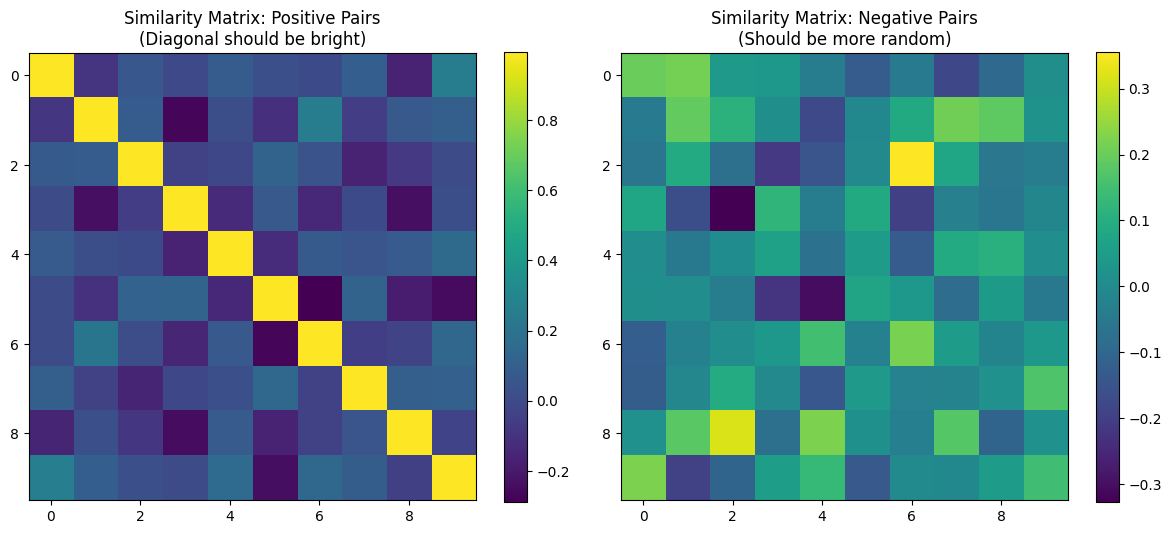

In [5]:
# now we get to demonstrate how contrastive the loss works!
def demo_contrastive_loss():
    # toy embeddings for demonstration
    batch_size = 10
    embedding_dim = 64
    
    # Same nodes, different views - this would what is referred to as an anchor (original data) and its augmented pair (a slightly altered version of the originla anchor)
    z1 = torch.randn(batch_size, embedding_dim)
    z2 = z1 + 0.1 * torch.randn(batch_size, embedding_dim)  # Similar to z1 (positive pairs) - the 0.1 is just adding a bit of noise to simulate augmentation
    
    #Different nodes (negative pairs) - 
    z3 = torch.randn(batch_size, embedding_dim)
    
    # Lets calculate losses!!
    model = ContrastiveGCN(in_channels=data.x.shape[1], hidden_channels=64, proj_dim=embedding_dim)
    pos_loss = model.contrastive_loss(z1, z2)
    neg_loss = model.contrastive_loss(z1, z3)
    
    print(f"Contrastive loss between similar embeddings: {pos_loss.item():.4f}")
    print(f"Contrastive loss between different embeddings: {neg_loss.item():.4f}")
    print(f"Difference (should be positive): {neg_loss.item() - pos_loss.item():.4f}")
    
    # Visualize similarity matrices
    z1_norm = torch.nn.functional.normalize(z1, dim=1)
    z2_norm = torch.nn.functional.normalize(z2, dim=1)
    z3_norm = torch.nn.functional.normalize(z3, dim=1)
    
    sim_pos = torch.mm(z1_norm, z2_norm.t())
    sim_neg = torch.mm(z1_norm, z3_norm.t())
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(sim_pos.detach(), cmap='viridis')
    plt.colorbar()
    plt.title("Similarity Matrix: Positive Pairs\n(Diagonal should be bright)")
    
    plt.subplot(1, 2, 2)
    plt.imshow(sim_neg.detach(), cmap='viridis')
    plt.colorbar()
    plt.title("Similarity Matrix: Negative Pairs\n(Should be more random)")
    
    plt.tight_layout()
    plt.show()

# Demo the contrastive loss
demo_contrastive_loss()

### In the positive grid (right), we have a 10×10 matrix where:

- Rows = nodes from embeddings z1 (view 1)
- Columns = nodes from embeddings z2 (view 2)
- Each cell [i,j] = similarity between node i in view 1 and node j in view 2
- The Diagonal (sim_pos[i,i]):

Shows similarity between the same node in two different views. 
Should be BRIGHT because node 0 in view 1 should be similar to node 0 in view 2. 
Diagonal = positive pairs (same nodes, different augmented views). 


### In the negative grid (left), we have a 10×10 matrix where:

Rows = nodes from embeddings z1 (view 1)
Columns = nodes from embeddings z3 (completely different nodes)
Each cell [i,j] = cosine similarity between node i from view 1 and node j from different nodes
The Entire Matrix (including diagonal):

Should be DARK/LOW everywhere because these are all different nodes
No special diagonal pattern expected - all similarities should be low and random

## Training with Contrastive Learning

Now let's train our model with the contrastive learning objective. We'll train for a limited number of epochs here, but for the full implementation we can go ahead and run the `main_contrastive.py` script in the main directory.

In [12]:
import importlib
import sys

# Reload contrastive_utils (this is where your changes are)
import contrastive_utils as cu
cu = importlib.reload(cu)
from contrastive_utils import (
    train_contrastive_model,
    evaluate_contrastive_model,
    create_graph_views,
)

# Also reload contrastive_gcn in case you changed that too
import contrastive_gcn as cg
cg = importlib.reload(cg)
from contrastive_gcn import ContrastiveGCN


In [13]:
# reload GCN modules and recreate the model to pick up updated layer signatures
import importlib
import sys
sys.path.append('../GCN') 

import gcn_layer as gl
import contrastive_gcn as cg

_ = importlib.reload(gl)
cg = importlib.reload(cg)
from contrastive_gcn import ContrastiveGCN

# Recreate model so its conv layers use the reloaded HigherOrderGCNLayer
contrastive_model = ContrastiveGCN(
    in_channels=data.x.shape[1],
    hidden_channels=256,
    proj_dim=128,
    tau=0.1,
)


Epoch 000 | Total: 28684.9668 | Coord: 28684.2285 | Contrast: 7.3863 | MSE: 28670.81 | MeanDist: 235.24 μm
Epoch 003 | Total: 28649.0820 | Coord: 28648.3945 | Contrast: 6.8704 | MSE: 28633.60 | MeanDist: 235.08 μm
Epoch 006 | Total: 28612.4961 | Coord: 28611.8477 | Contrast: 6.4813 | MSE: 28588.78 | MeanDist: 234.89 μm
Epoch 009 | Total: 28557.3379 | Coord: 28556.7148 | Contrast: 6.2263 | MSE: 28519.46 | MeanDist: 234.59 μm
Epoch 012 | Total: 28472.4863 | Coord: 28471.8672 | Contrast: 6.1979 | MSE: 28413.43 | MeanDist: 234.13 μm
Epoch 015 | Total: 28339.4141 | Coord: 28338.8086 | Contrast: 6.0521 | MSE: 28250.66 | MeanDist: 233.42 μm
Epoch 018 | Total: 28144.9629 | Coord: 28144.3594 | Contrast: 6.0359 | MSE: 28007.45 | MeanDist: 232.37 μm
Epoch 021 | Total: 27849.5527 | Coord: 27848.9512 | Contrast: 6.0135 | MSE: 27650.71 | MeanDist: 230.81 μm
Epoch 024 | Total: 27418.8105 | Coord: 27418.2109 | Contrast: 5.9994 | MSE: 27137.28 | MeanDist: 228.54 μm
Epoch 027 | Total: 26818.6113 | Coord

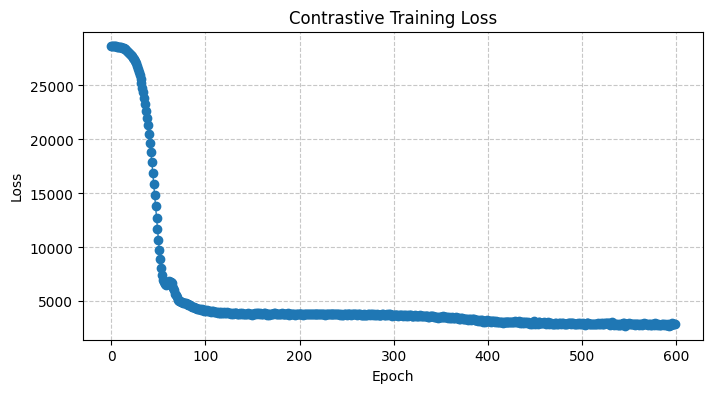

In [14]:
#setup optimizer and loss function
optimizer = torch.optim.Adam(contrastive_model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

# compute adj_powers for the model (example: up to 3rd power)
def compute_adj_powers(G, max_power=3):
    import scipy.sparse as sp
    A = nx.to_scipy_sparse_array(G, format='csr')
    adj_powers = [torch.tensor((A ** k).toarray(), dtype=torch.float32) for k in range(1, max_power + 1)]
    return adj_powers

# Note: We don't need adj_powers for the current implementation

# Train for just 10 epochs for demonstration

import time
start = time.time()
try:
    contrastive_model, train_losses = train_contrastive_model(
        contrastive_model,
        data,
        optimizer,
        criterion,
        num_epochs=600,
        lambda_contrast=0.1,
        edge_dropout_prob=0.1,      # milder augmentation for stability
        feature_mask_prob=0.1,      # milder feature masking
        log_every=3,                # print every epoch for visibility
    )
    print(f"Training finished in {time.time() - start:.1f}s")
except Exception as e:
    import traceback
    print("Training failed with error:\n", e)
    traceback.print_exc()
    raise


plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o', linewidth=1)
plt.title("Contrastive Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Evaluate Contrastive Learning Results

Let's evaluate our model's performance on the coordinate prediction task.

COORDINATE PREDICTION RESULTS:
Mean Squared Error: 2689.7524
Mean Absolute Error: 42.5373
Mean Distance Error: 65.60 μm
Median Distance Error: 61.95 μm
X-coordinate correlation: 0.5884
Y-coordinate correlation: 0.4987


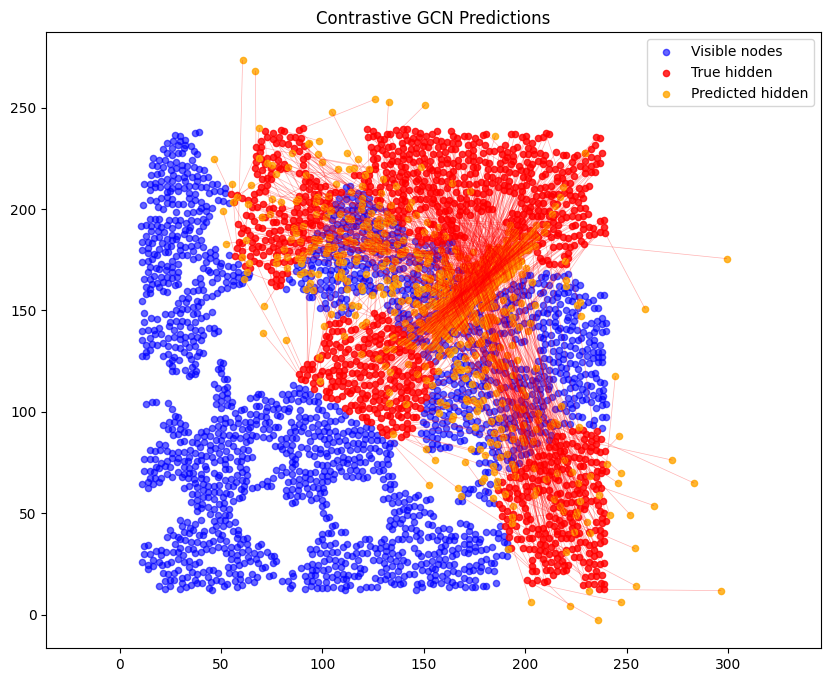

In [15]:
# Evaluate the contrastive model
results = evaluate_contrastive_model(contrastive_model, data)

# Print results
print("COORDINATE PREDICTION RESULTS:")
print(f"Mean Squared Error: {results['mse']:.4f}")
print(f"Mean Absolute Error: {results['mae']:.4f}")
print(f"Mean Distance Error: {results['mean_distance_error']:.2f} μm")
print(f"Median Distance Error: {results['median_distance_error']:.2f} μm")
print(f"X-coordinate correlation: {results['correlation_x']:.4f}")
print(f"Y-coordinate correlation: {results['correlation_y']:.4f}")

# Visualize predictions
def visualize_predictions(data, model):
    model.eval()
    with torch.no_grad():
        pred_coords = model(data)
    
    # Get coordinates and predictions
    true_coords = data.target_coords.numpy()
    pred_coords_np = pred_coords.numpy()
    
    visible_mask = data.visible_mask.numpy()
    hidden_mask = data.hidden_mask.numpy()
    
    plt.figure(figsize=(10, 8))
    
    # Plot visible nodes
    plt.scatter(true_coords[visible_mask, 0], true_coords[visible_mask, 1], 
               c='blue', alpha=0.6, s=20, label='Visible nodes')
    
    # Plot true hidden nodes
    plt.scatter(true_coords[hidden_mask, 0], true_coords[hidden_mask, 1], 
               c='red', alpha=0.8, s=20, label='True hidden')
    
    # Plot predicted hidden nodes
    plt.scatter(pred_coords_np[hidden_mask, 0], pred_coords_np[hidden_mask, 1], 
               c='orange', alpha=0.8, s=20, label='Predicted hidden')
    
    # Draw error lines
    for i in np.where(hidden_mask)[0]:
        plt.plot([true_coords[i, 0], pred_coords_np[i, 0]], 
                [true_coords[i, 1], pred_coords_np[i, 1]], 
                'r-', alpha=0.3, linewidth=0.5)
    
    plt.title('Contrastive GCN Predictions')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Visualize predictions
visualize_predictions(data, contrastive_model)

## Notes for how to possibly proceed

above, We have applied a nuclei coordinate prediction task.

Some directions for further exploration:

1. **Augmentation strategies**: Experiment with different graph augmentations like subgraph sampling, edge perturbation, and feature normalization.

2. **Projection head design**: Try different architectures for the projection head used in contrastive learning.

3. **Contrastive loss variants**: Implement other contrastive objectives like BYOL, MoCo, or SimCLR.

4. **Nuclei clustering**: Use the learned embeddings to cluster nuclei and identify regions with similar topological properties.
